In [168]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import keras

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_27816\3517338504.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [169]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [170]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5,0.5,0.5],
        std =[0.5,0.5,0.5]
        ),
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])

In [171]:
# Step 2: convert into pytorch dataset 
train_data = torchvision.datasets.CIFAR10(
                                root='./data', 
                                download=True, 
                                train=True, 
                                transform=transform)

Files already downloaded and verified


In [172]:
train_data.data.shape

(50000, 32, 32, 3)

In [173]:
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

In [174]:
#train_dataT = torch.tensor(reshaped_data).float()

In [175]:
# parameters
#inChans  = 3 # RGB
#outChans = 15
#krnSize  = 5 # should be an odd number
#stride   = 1
#padding  = 0

#imsize   = [256,256]

## create the instance
#c = nn.Conv2d         (inChans,outChans,krnSize,stride,padding)
#c = nn.ConvTranspose2d(inChans,outChans,krnSize,stride,padding)

# create an image
#img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
#resimg = c(img)
#empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
#expectSize = np.array([outChans,0,0],dtype=int)
#expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
#expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
#print(f'Expected size: {expectSize}')
#print(f'Empirical size: {list(empSize)}')

In [176]:
# **) size of transpose convolution formula "to calculate the image size of the transpose convolution"
# **) # of pixels in output image = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
# **)                       Nh    = Sh      * (Mh                         - 1) + K                               - 2*P
# #
# *) size of convolution formula "to calculate the image size of convolution"
# *) # of pixels in current layer = Floor ( (# of pixels in previous layer  + 2*Padding - # of pixels in kernel height) / Stride ) + 1
# *)                        Nh    = Floor ( ( Mh                            + 2*P       - K                           ) / Sh     ) + 1
# *) expectSize = np.array([outChans, 0, 0], dtype=int)
# *) expectsize[1] = np.floor( (imsize[0] + 2*padding - krnSize) / stride[0] ) + 1
# *) expectsize[2] = np.floor( (imsize[1] + 2*padding - krnSize) / s/tride[1] ) + 1
# #
# 1) Image (channels   X Width  X Height)
# 1) Image (1          X i/p 28 X i/p 28)
# #
# 2) Conv1 (# of feature maps kernels   X o/p Width X o/p Height)
# 2) Conv1 ( 10                         X 26        X 26        ) #lost 1 pixel left & 1 pixel right (1 pixel top & 1 pixel bottom) 
# #
# 3) maxpool1 (# of feature maps kernels X o/p width X o/p Height)
# 3) maxpool1 (10                        X 13        X 13        ) #2x2 maxpool * 26x26 = 13 x 13
# #
# 4) Conv2 (# of feature maps kernels   X o/p Width X o/p Height)
# 4) Conv2 (20                          X 11        X 11        )
# #
# 5) maxpool2 (# of feature maps kernels X o/p width X o/p Height)
# 5) maxpool2 (20                        X 5        X 5        ) #2x2 maxpool * 26x26 = 13 x 13
# #
# 6) ANN layer (1X50)

In [177]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            ### --- Encoding Layer --- ###
            
            inChans  = 3 # RGB
            outChans = 16 # feature maps # of kernels
            krnSize  = 4 # odd number
            padding  = 1 # square if single input
            stride   = 2 # use maxpool instead of stride ... so stride = 1
            
            # First Convolution Layer
            self.enc_conv1  = nn.Conv2d(inChans,    outChans,    krnSize, stride, padding)
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (32 + 2*1 - 3) / 1 ) + 1 = 32
            # output size = 32/2 = 16 b/c of avgpool
            
            # Second Convolution Layer
            self.enc_conv2  = nn.Conv2d(outChans,   outChans*2,  krnSize, stride, padding)
            # output size = floor( (16 + 2*0 - 3) / 1 ) + 1 = 14
            # output size = 14/2 = 7 b/c of avgpool

            # Latent Layer
            self.enc_latent  = nn.Conv2d(outChans*2,outChans*2*2,krnSize, stride, padding)
            # output size = floor( (7 + 2*0 - 3) / 1 ) + 1 = 5
            # output size = 5/2 = 2 b/c of avgpool

            ### --- Decoding Layer --- ###
            
            # Latent Layer
            self.dec_latent  = nn.ConvTranspose2d(outChans*2*2,outChans*2,krnSize, stride, padding)
            
            # First Convolution Transpose Layer
            self.dec_conv1   = nn.ConvTranspose2d(outChans*2  ,outChans  ,krnSize, stride, padding)

            # Second Convolution Transpose Layer
            self.dec_conv2   = nn.ConvTranspose2d(outChans    ,inChans   ,krnSize, stride, padding)
            
            
        def forward(self, x):
            
            if self.print: print(f'Input: {list(x.shape)}')
            
            # Encoding Layer
            #CPBR block
            x = F.leaky_relu( self.enc_conv1(x))
            if self.print: print(f'First Enc Conv: {list(x.shape)}')
            
            x = F.leaky_relu( self.enc_conv2(x))
            if self.print: print(f'Second Enc Conv: {list(x.shape)}')

            x = F.leaky_relu( self.enc_latent(x))
            if self.print: print(f'Latent Enc: {list(x.shape)}')
            
            x = F.leaky_relu( self.dec_latent(x))
            if self.print: print(f'Latent Dec: {list(x.shape)}')
            
            x = F.leaky_relu( self.dec_conv1(x))
            if self.print: print(f'First Dec Conv: {list(x.shape)}')

            x = ( self.dec_conv2(x))
            if self.print: print(f'Second Dec Conv: {list(x.shape)}')
                        
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001, weight_decay=1e-5)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

In [178]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=20):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
    trainLoss   = []
    
    for epochi in range(numepochs):
        
        batchLoss = []
        #get a permuted index vector
                
        for X, y in train_loader:
            
            X = X.to(device)
            y = y.to(device)
            
            #forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, X)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #losses in this batch
            batchLoss.append(loss.item())
            
        trainLoss.append(np.mean(batchLoss))
    
    return trainLoss, trainedModel            


In [ ]:
# test the Model & train
myModelInstance2, lossfun2, optimizer2 = createTheNet(True)
trainLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs=1)

In [180]:
# Train the Model
myModelInstance, lossfun, optimizer = createTheNet(False)
trainLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)

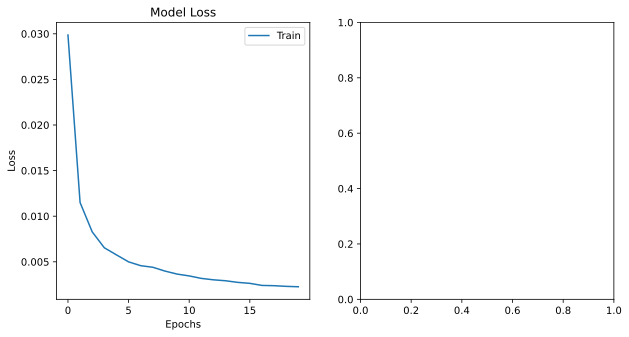

In [181]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, label='Train')
# ax[0].plot(devLoss, label='Dev')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

# ax[1].plot(trainAcc, label='Train')
# ax[1].plot(devAcc, label='Test')
# ax[1].legend()
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title(f'Train accuracy {trainAcc[-1]:.2f}%')
# ax[1].set_ylim([0,110])

plt.show()